In [1]:
# Install required packages
# You can run this in your terminal or uncomment and run in a Jupyter notebook
# !pip install roboflow opencv-python matplotlib faiss-cpu ultralytics transformers

# Import necessary libraries
import torch
from PIL import Image
import numpy as np
import pandas as pd
import faiss
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2
from roboflow import Roboflow
import requests
from transformers import AutoImageProcessor, Dinov2Model
import io


# Initialize Roboflow API and load a specific project and model version
rf = Roboflow(api_key="fzoL6Dj2WntmtiY0gyrF")
project_clothes = rf.workspace().project("clothes-dataset-e9wyj")
model_clothes = project_clothes.version(2).model

# Define paths to the FAISS index and CSV file containing image data
# Update these paths to point to the correct locations on your local machine
index_path = "../Combined_Data/faiss_index_combined.bin"
csv_path = "../Combined_Data/combined.csv"

# Load the FAISS index and CSV file, and initialize DINO models
print("Loading FAISS index and CSV data...")
index = faiss.read_index(index_path)
df = pd.read_csv(csv_path)
print("FAISS and CSV loaded successfully.")

processor_dino = AutoImageProcessor.from_pretrained("facebook/dinov2-base")
model_dino = Dinov2Model.from_pretrained("facebook/dinov2-base")
print("Models loaded successfully.")

def dinoFeatureExtractor(cropped_image):
    """Extract features from a cropped image using the DINO model."""
    print("Extracting features using DINO model...")
    processed_image = Image.fromarray(cropped_image)
    query_inputs = processor_dino(images=[processed_image], return_tensors="pt")
    with torch.no_grad():
        query_image_features = model_dino(**query_inputs)
        image_features = query_image_features.last_hidden_state.mean(dim=1)
    print("Features extracted successfully.")
    return image_features.numpy()

def query_faiss(image_features, k=10):
    """Query the FAISS index with the extracted image features to find similar images."""
    print("Querying FAISS index...")
    query_features = image_features.squeeze()
    distances, indices = index.search(np.expand_dims(query_features, axis=0), k)
    print("Query completed. Retrieving results from DataFrame...")
    images_data = []
    for i, (distance, idx) in enumerate(zip(distances[0], indices[0])):
        print(f"{i}: {df.iloc[idx]['Downloaded Image URL']} with distance {distance:.2f}")
        images_data.append({'url': df.iloc[idx]['Downloaded Image URL'], 'distance': distance})
    return images_data

def display_image_grid(images_data, ncols=5):
    """Display a grid of images with distances from the FAISS query result."""
    nrows = int(np.ceil(len(images_data) / ncols))
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 15))
    ax = ax.flatten()
    for i, img_data in enumerate(images_data):
        try:
            print(f"Fetching image {i} from URL: {img_data['url']}")
            response = requests.get(img_data['url'], stream=True, timeout=10)
            response.raise_for_status()
            img = Image.open(io.BytesIO(response.content))
            ax[i].imshow(img)
            ax[i].axis('off')
            ax[i].set_title(f"Dist: {img_data['distance']:.2f}")
        except requests.exceptions.RequestException as e:
            print(f"Error fetching image {i}: {e}")
            ax[i].axis('off')
            ax[i].set_title("Image not available")
        except Exception as e:
            print(f"Error displaying image {i}: {e}")
            ax[i].axis('off')
            ax[i].set_title("Display error")
    # Hide any unused subplots
    for j in range(i+1, len(ax)):
        ax[j].axis('off')
    plt.tight_layout()
    plt.show()

def process_image(image_path):
    """Load an image, perform object detection, extract features, query FAISS, and display results."""
    print("Performing object detection...")
    prediction_clothes = model_clothes.predict(image_path, confidence=40, overlap=30).json()

    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    detections = []
    for i, item in enumerate(prediction_clothes['predictions']):
        x, y, w, h = item['x'], item['y'], item['width'], item['height']
        start_point = (int(x - w/2), int(y - h/2))
        detections.append({'bbox': (start_point[0], start_point[1], int(w), int(h)), 'class': item['class'], 'confidence': item['confidence']})
        print(f"{i}: Class: {item['class']}, Confidence: {item['confidence']:.2f}, Box: {start_point[0]}, {start_point[1]}, {w}, {h}")

    index = int(input("Enter the index of the detection to process: "))
    selected_detection = detections[index]
    x, y, w, h = selected_detection['bbox']

    # Display the original image with the selected bounding box
    plt.figure(figsize=(8, 8))
    plt.imshow(image_rgb)
    rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='r', facecolor='none')
    plt.gca().add_patch(rect)
    plt.title("Original Image with Selected Detection")
    plt.axis('off')
    plt.show()

    # Display the cropped part of the image
    cropped_image = image_rgb[y:y+h, x:x+w]
    plt.figure(figsize=(5, 5))
    plt.imshow(cropped_image)
    plt.title("Cropped Image")
    plt.axis('off')
    plt.show()

    image_features = dinoFeatureExtractor(cropped_image)
    results = query_faiss(image_features)
    display_image_grid(results)




IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


loading Roboflow workspace...
loading Roboflow project...
Loading FAISS index and CSV data...
FAISS and CSV loaded successfully.
Models loaded successfully.


Performing object detection...
0: Class: sleeveless, Confidence: 0.70, Box: 0, 1298, 923, 1635
1: Class: short-pants, Confidence: 0.63, Box: 0, 1261, 894, 1681


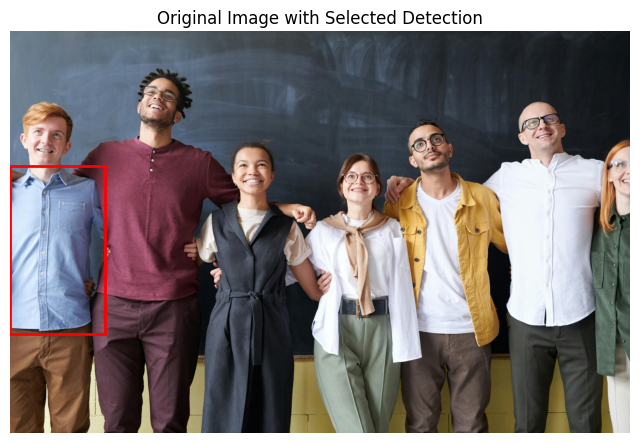

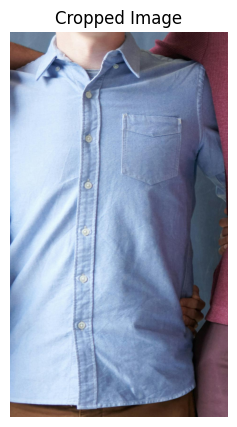

Extracting features using DINO model...
Features extracted successfully.
Querying FAISS index...
Query completed. Retrieving results from DataFrame...
0: https://lamaretail.com/cdn/shop/files/HUMMST0012-WHITE-SAFARI-SHIRT_10.jpg?v=1692164524&width=1000 with distance 392.49
1: https://lamaretail.com/cdn/shop/files/HSLMST0001-GREY-HIGH-NECK-SWEATER_2.jpg?v=1701237930&width=1000 with distance 420.44
2: https://lamaretail.com/cdn/shop/files/SNCMWT0004-BLACK-RELAXED-CREW-NECK-SWEATER_2.jpg?v=1697721240&width=1080 with distance 424.37
3: https://lamaretail.com/cdn/shop/files/SAPMWT0005-MIDNIGHT-BLUE-EVERYDAY-SWEATSHIRT_2.jpg?v=1702899663&width=1000 with distance 425.04
4: https://lamaretail.com/cdn/shop/files/MAS24TP011-DARK-BROWN-JACQUARD-TEE.jpg?v=1724216310&width=1000 with distance 455.14
5: https://lamaretail.com/cdn/shop/files/STYMWB0001-BLACK-SLIM-FIT-JEANS_2.jpg?v=1701669740&width=1000 with distance 457.05
6: https://lamaretail.com/cdn/shop/files/SAPMWT0009-OLIVE-EVERYDAY-WAFFLE-SWEAT

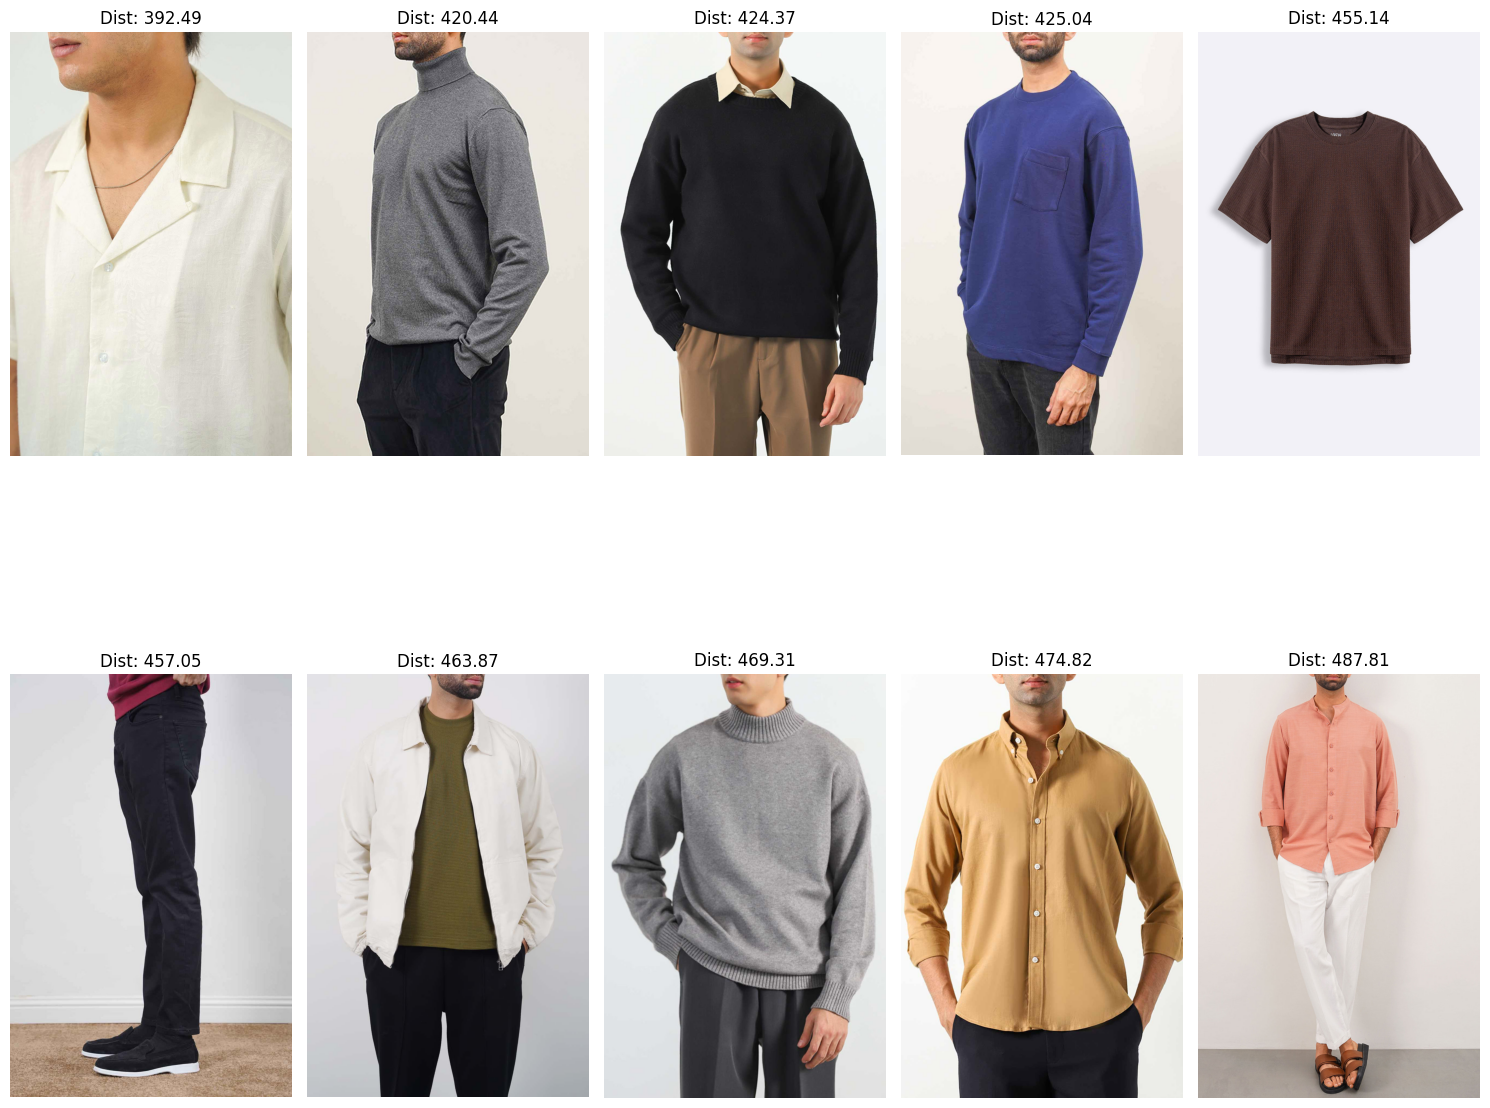

In [5]:
# Specify the path to your test image
test_image_path = "/Users/abdullahmac/Desktop/FAST/Hisham FYP/Own Implementation/Test/Test1.jpg"  # Replace with the path to your image file
# Run the processing function
process_image(test_image_path)